In [59]:
import os
import math
import datetime
import pandas as pd

def calculate_h_index(quotation): #h_ndex
    quotation.sort(reverse=True)  # 논문을 내림차순으로 정렬

    h_index = 0
    for i, quotation in enumerate(quotation):
        if quotation >= i + 1:
            h_index = i + 1
        else:
            break

    return h_index

def calculate_i10_index(quotation):  #i10_index
    i10_index = sum(1 for quotation in quotation if quotation >= 10)
    return i10_index

def calculate_g_index(quotation):  #g_index
    quotation.sort(reverse=True)  # 논문을 내림차순으로 정렬

    g_index = 0
    quotation_sum=0
    for i, quotation in enumerate(quotation):
        quotation_sum+=quotation
        if quotation_sum >= (i + 1)**2:
            g_index = i + 1

    return g_index

#Object 타입에서 숫자형 체크용
def is_numeric(value):
    try:
        float(value)  # float으로 변환 가능한 경우 숫자
        return True
    except (ValueError, TypeError):
        return False

def recentness(pYears):
    # dt = datetime.datetime.now()#현재날짜
    dt = 2013
    rct = 0
    lct = 0
    if len(pYears) == 0:
        rct = 0
        lct = 0
    else:
        year_avg = sum(pYears) / len(pYears)
        if year_avg >= int(dt)-2: #int(dt.year)-2:
            lct = 1
        # else:
        #     lct = max(round((1-(int(dt)-3-year_avg)*0.1),2), 0)
        elif int(dt)-15 < year_avg <= int(dt)-3:
            lct = max(round((1-(int(dt)-3-year_avg)*0.1),2), 0)

        rct += len(pYears) #연도 개수

    return rct, lct

In [60]:
from pymongo import MongoClient
from bson.objectid import ObjectId
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', None)


client = MongoClient('mongodb://10.255.92.141:27017', authSource='admin')

# keyid = 2157 #input
# idTest = client['ID']['test'] #Domestic
# publicNewfactor = client['PUBLIC']['new_factor']
# idTest_keyid = idTest.find({ 'keyId' : keyid })
# maxFactor = publicNewfactor.find_one({'keyId' : keyid})

# a = idTest.count_documents({ 'keyId' : keyid })
# print(a)

keyid2=2030
idTest = client['ID']['test'] #Domestic
idInter_keyid = idTest.find({ 'keyId' : keyid2 })
publicNewfactor_inter = client['PUBLIC']['new_factor_inter']
maxFactor_inter = publicNewfactor_inter.find_one({'keyId' : keyid2})

b = idTest.count_documents({ 'keyId' : keyid2 })

sites = ["WOS"]
name=[]
sco=[]
h_idx=[]
i10_idx=[]
g_idx=[]

df = pd.DataFrame({
    'name': name,
    'score': sco,
    'h_index': h_idx,
    'i10_index': i10_idx,
    'g_index': g_idx
})

for i in idInter_keyid:
    citations = []
    years = []
    A_id=[]
    for site in sites:
        if site in i.keys():
            papersIds = i[site]["papers"]

            for paper in papersIds:
                idSite = client[site]['Rawdata'] 
                idSite_pId = idSite.find_one({ '_id' : ObjectId(str(paper)) })

                citations.append(int(idSite_pId["citation"]))
                years.append(int(idSite_pId["issue_year"]))
                
            h_index = calculate_h_index(citations)
            i10_index = calculate_i10_index(citations)
            g_index = calculate_g_index(citations)

    A_id=i['name']
    lct = i['factor']['lct'] #생산성
    rct = i['factor']['rct'] #생산성
    acc = i['factor']['acc'] #주제적합도
    qual = i['factor']['interQual'] #품질
    norm_scoquality = qual/maxFactor_inter['interQual'] #정규화된 품질
    norm_recentness = ((rct/maxFactor_inter['recentness'])+lct)*0.66 #정규화된 생산성

    score = (norm_scoquality + norm_recentness + acc)/3*100
    # print(f'citations: {citations}, years: {years}')

    new_data={'name': A_id, 'score': score, 'h_index': h_index, 'i10_index': i10_index, 'g_index':g_index}

    df = pd.concat([df, pd.DataFrame(new_data, index=[0])], ignore_index=True)

df_score = df.sort_values(by='score', ascending=False)
df_h = df.sort_values(by='h_index', ascending=False)
df_i10 = df.sort_values(by='i10_index', ascending=False)
df_g = df.sort_values(by='g_index', ascending=False)
print(df_score)

                          name      score  h_index  i10_index  g_index
23              Kim, Sang-Wook  95.818808     11.0       12.0     12.0
30                  Yu, Hwanjo  88.666667     12.0       12.0     12.0
32             Kim, Jae Kyeong  83.062936      8.0        8.0      9.0
25              Jung, Jason J.  68.767853      6.0        6.0      6.0
93                Lee, Jongwuk  59.695692      4.0        4.0      4.0
139                 Lee, Suwon  54.903393      3.0        3.0      3.0
115              Kim, Jaekwang  51.254522      3.0        2.0      3.0
116                 Lee, Daeho  50.703862      2.0        2.0      2.0
131            Jang, Beakcheol  50.617604      2.0        2.0      2.0
5               Park, Sanghyun  50.456588      2.0        2.0      2.0
82                Ham, Tae Jun  50.443168      2.0        2.0      2.0
74              Shin, Won-Yong  50.345205      2.0        2.0      2.0
102         Whangbo, Taeg Keun  50.272768      2.0        2.0      2.0
135   

In [61]:
df_score = df_score.reset_index(drop=True)
H_sorted = df_h.reset_index(drop=True)
I10_sorted = df_i10.reset_index(drop=True)
G_sorted = df_g.reset_index(drop=True)

df_score['rank'] = df_score['score'].rank(method='min', ascending=False).astype(int)
H_sorted['rank'] = H_sorted['h_index'].rank(method='min', ascending=False).astype(int)
I10_sorted['rank'] = I10_sorted['i10_index'].rank(method='min', ascending=False).astype(int)
G_sorted['rank'] = G_sorted['g_index'].rank(method='min', ascending=False).astype(int)

new_df = pd.concat([df_score['name'],df_score['score'],df_score['rank'], H_sorted['name'],H_sorted['h_index'],H_sorted['rank'], I10_sorted['name'],I10_sorted['i10_index'],I10_sorted['rank'], G_sorted['name'],G_sorted['g_index'],G_sorted['rank'],], axis=1)
new_df = new_df.reset_index(drop=True)
new_df.columns = ['name', 'score','rank', 'name','h_score','rank', 'name','i10_score','rank', 'name','g_score','rank']



print(H_sorted)

                          name      score  h_index  i10_index  g_index  rank
0                   Yu, Hwanjo  88.666667     12.0       12.0     12.0     1
1               Kim, Sang-Wook  95.818808     11.0       12.0     12.0     2
2              Kim, Jae Kyeong  83.062936      8.0        8.0      9.0     3
3               Jung, Jason J.  68.767853      6.0        6.0      6.0     4
4                 Lee, Jongwuk  59.695692      4.0        4.0      4.0     5
5                   Lee, Suwon  54.903393      3.0        3.0      3.0     6
6                Kim, Jaekwang  51.254522      3.0        2.0      3.0     6
7                 Lee, Soojung  42.928286      2.0        2.0      2.0     8
8                   Lee, Daeho  50.703862      2.0        2.0      2.0     8
9              Jang, Beakcheol  50.617604      2.0        2.0      2.0     8
10               Lee, Kyungjae  49.609133      2.0        2.0      2.0     8
11               Kim, Hyungjin  39.133125      2.0        2.0      2.0     8

In [62]:
all_ranks = pd.concat([H_sorted, I10_sorted, G_sorted])

# 이름을 기준으로 등수 합계 계산
rank_sum = all_ranks.groupby('name').sum().reset_index()

# 결과 출력
# print(rank_sum)

rank_sum = rank_sum.sort_values(by='rank', ascending=True)
rank_sum=rank_sum.reset_index(drop=True, inplace=False)

print(rank_sum)

                          name       score  h_index  i10_index  g_index  rank
0                   Yu, Hwanjo  266.000000     36.0       36.0     36.0     3
1               Kim, Sang-Wook  287.456425     33.0       36.0     36.0     4
2              Kim, Jae Kyeong  249.188807     24.0       24.0     27.0     9
3               Jung, Jason J.  206.303560     18.0       18.0     18.0    12
4                 Lee, Jongwuk  179.087076     12.0       12.0     12.0    15
5                   Lee, Suwon  164.710178      9.0        9.0      9.0    18
6                Kim, Jaekwang  153.763567      9.0        6.0      9.0    19
7                    Sohn, Mye   96.776369      6.0        6.0      6.0    23
8                Kim, Hyungjin  117.399375      6.0        6.0      6.0    23
9                Lee, Kyungjae  148.827400      6.0        6.0      6.0    23
10          Abro, Waheed Ahmed   53.330548      6.0        6.0      6.0    23
11                Lee, Soojung  128.784859      6.0        6.0  

In [68]:
rank_sum50=rank_sum[0:100]

print(rank_sum50)
#몇등까지 보실래요
rank=50 #사용자가 수정

score_list=df_score['name'].values
# score_list=H_sorted['name'].values
# score_list=G_sorted['name'].values
# score_list=I10_sorted['name'].values

answer_list=rank_sum50['name'].values

#몇등까지 보실래요
rank=10 #사용자가 수정

                     name       score  h_index  i10_index  g_index  rank
0              Yu, Hwanjo  266.000000     36.0       36.0     36.0     3
1          Kim, Sang-Wook  287.456425     33.0       36.0     36.0     4
2         Kim, Jae Kyeong  249.188807     24.0       24.0     27.0     9
3          Jung, Jason J.  206.303560     18.0       18.0     18.0    12
4            Lee, Jongwuk  179.087076     12.0       12.0     12.0    15
5              Lee, Suwon  164.710178      9.0        9.0      9.0    18
6           Kim, Jaekwang  153.763567      9.0        6.0      9.0    19
7               Sohn, Mye   96.776369      6.0        6.0      6.0    23
8           Kim, Hyungjin  117.399375      6.0        6.0      6.0    23
9           Lee, Kyungjae  148.827400      6.0        6.0      6.0    23
10     Abro, Waheed Ahmed   53.330548      6.0        6.0      6.0    23
11           Lee, Soojung  128.784859      6.0        6.0      6.0    23
12        Jang, Beakcheol  151.852812      6.0     

In [69]:
# #몇등까지 보실래요
# rank=10 #사용자가 수정

# score_list=[]
# satisfied_list=[]

# h_list=[]
# i10_list=[]
# g_list=[]

# for index, row in new_df.iterrows():
#     score_list.append(row['name'])  
#     if index >= rank-1:  
#         break

# index_score=(new_df['h_score'][rank]+new_df['g_score'][rank]+new_df['i10_score'][rank])//3

# for index, row in new_df.iterrows():
#     if row['h_score']>=index_score:
#         h_list.append(row['h_name'])
#     if row['i10_score']>=index_score:
#         i10_list.append(row['i10_name'])
#     if row['g_score']>=index_score:
#         g_list.append(row['g_name'])

# answer_list=[]

# for array in [h_list, i10_list, g_list]:  # 배열의 순서대로 처리
#     for item in array:
#         if item not in answer_list:  # 결과 리스트에 아직 없는 요소만 추가
#             answer_list.append(item)


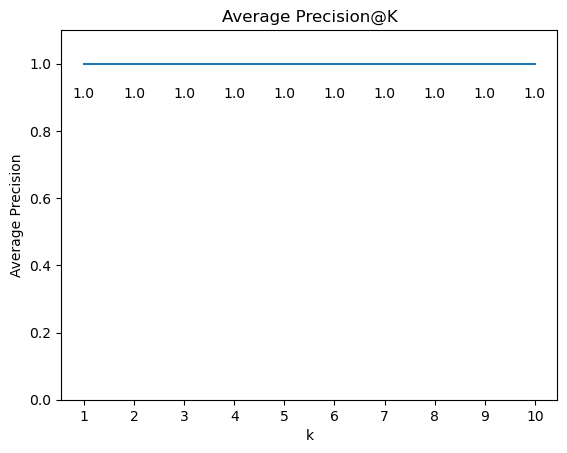

In [70]:
#Average precision@K
#k=rank 추천받을 사람 수
#rel=3개 지수가 만든 저자 목록에 전문가지수가 만든 저자가 포함 되어있다면 1, 아니라면 0
#m+사용자가 추천받은 것들 중 만족한 개수
import matplotlib.pyplot as plt

rel_list=score_list
rel_list = [1 if item in answer_list else 0 for item in score_list]
precision_list=[]
cnt_1=0
for k in range(rank):
    if rel_list[k]==1:
        cnt_1+=1

    precision_k=round(cnt_1/(k+1), 3)
    precision_list.append(precision_k)

k_list = list(range(1, rank + 1))

# 선 그래프 그리기
plt.plot(k_list, precision_list)
plt.ylim(0, 1.1)

for i in range(len(k_list)):
    plt.text(k_list[i], precision_list[i] - 0.1, str(precision_list[i]), ha='center')

plt.xticks(range(1, 11))

# 그래프 제목 설정
plt.title("Average Precision@K")

# x축, y축 라벨 설정
plt.xlabel("k")
plt.ylabel("Average Precision")

# 그래프 보여주기
plt.show()


[10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, -1, -2, -3, -4, 0, -6, -7, -8, -9, -10, -11, -12, 0, 0, -15, -16, -17, -18, 0, -20, 0, -22, -23, -24, -25, -26, -27, 0, -29, -30, -31, -32, -33, -34, -35, -36, 0, -38, -39, -40, -41, 0, -43, -44, 0, 0, 0, -48, -49, -50, -51, -52, 0, -54, -55, -56, 0, -58, 0, 0, -61, -62, -63, 0, -65, -66, -67, 0, 0, -70, -71, 0, 0, -74, -75, -76, 0, -78, -79, 0, 0, -82, 0, 0, -85, -86, -87, -88, -89, 0, 0, -92, 0, 0, 0, -96, 0, 0, -99, -100, 0, 0, 0, 0, 0, -106, -107, 0, -109, -110, 0, 0, -113, -114, -115, 0, -117, 0, 0, -120, -121, -122, -123, 0, 0, -126, -127, -128, 0, -130, 0, 0, -133, 0, -135, 0, 0, -138, -139, 0, -141]
[10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
[10, 19.0, 24.047438028571662, 27.547438028571662, 30.13149737701202, 32.06576141318473, 33.49059016161682, 34.49059016161682, 35.12151991518828, 35.42254991085226]
[10, 19.0, 24.047438028571662, 27.547438028571662, 30.13149737701202, 32.06576141318473, 33.49059016161682, 34.49059016161682, 35.12151991518828, 35.4225

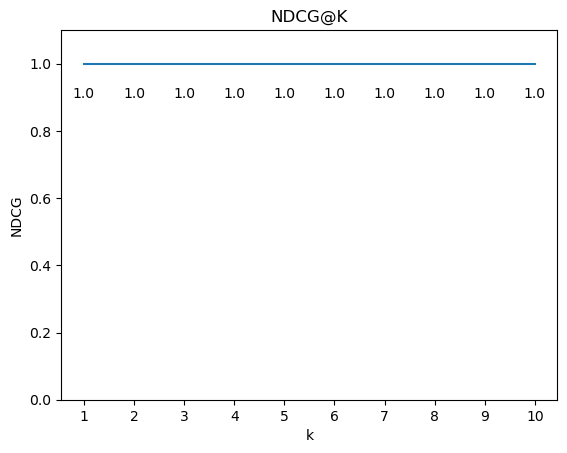

In [71]:
#NDCG@K
#NDCG=DCG/IDCG
import math

i=rank
rel_rank_list=[]
for item in score_list:
    if item in answer_list:
        rel_rank_list.append(i)  # 순위 추가
    else:
        rel_rank_list.append(0)  # 해당 항목이 answer_list에 없으면 0 추가
    i -= 1

print(rel_rank_list)

i=0
ideal_rel_rank_list = [i+1 for i in range(rank)]
ideal_rel_rank_list=ideal_rel_rank_list[::-1]
print(ideal_rel_rank_list)

DCG_list = [0] * rank

for k in range(rank):
    # k=0일 때 log2(1)은 0이므로, 분모가 0이 되는 것을 방지
    if k > 0:
        DCG_list[k] = (rel_rank_list[k]/math.log2(k+1)) + DCG_list[k-1]
    else:
        DCG_list[k] = rel_rank_list[k]
print(DCG_list)


IDCG_list = [0] * rank

for k in range(rank):
    # k=0일 때 log2(1)은 0이므로, 분모가 0이 되는 것을 방지
    if k > 0:
        IDCG_list[k] = (ideal_rel_rank_list[k]/math.log2(k+1)) + IDCG_list[k-1]
    else:
        IDCG_list[k] = ideal_rel_rank_list[k]

print(IDCG_list)
NDCG_list=[0] * rank
for k in range(rank):
    NDCG_list[k]=round(DCG_list[k]/IDCG_list[k],3)
print(NDCG_list)

k_list = list(range(1, rank + 1))
print(NDCG_list)
# 선 그래프 그리기
plt.plot(k_list, NDCG_list)
plt.ylim(0, 1.1)

for i in range(len(k_list)):
    plt.text(k_list[i], NDCG_list[i] - 0.1, str(NDCG_list[i]), ha='center')

plt.xticks(range(1, 11))

# 그래프 제목 설정
plt.title("NDCG@K")

# x축, y축 라벨 설정
plt.xlabel("k")
plt.ylabel("NDCG")

# 그래프 보여주기
plt.show()


In [67]:
for col in new_df.columns:
    index = new_df[col].where(new_df[col] == 'Zhang, Zhaoxiang').dropna().index
    print(f"In column '{col}', 'value' is located at index: {index}")


In column 'name', 'value' is located at index: Index([], dtype='int64')
In column 'score', 'value' is located at index: Index([], dtype='int64')
In column 'rank', 'value' is located at index: Index([], dtype='int64')
In column 'name', 'value' is located at index: Index([], dtype='int64')
In column 'h_score', 'value' is located at index: Index([], dtype='int64')
In column 'rank', 'value' is located at index: Index([], dtype='int64')
In column 'name', 'value' is located at index: Index([], dtype='int64')
In column 'i10_score', 'value' is located at index: Index([], dtype='int64')
In column 'rank', 'value' is located at index: Index([], dtype='int64')
In column 'name', 'value' is located at index: Index([], dtype='int64')
In column 'g_score', 'value' is located at index: Index([], dtype='int64')
In column 'rank', 'value' is located at index: Index([], dtype='int64')
